<a href="https://colab.research.google.com/github/Eduard953/Image_Processing_SS20/blob/master/Assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Processing SS 20 - Assignment - 11

### Deadline is 08.07.2020 at 11:55am.

Eduard Beiline, Bernard Breljak

You can achieve 20 points, of which 10 points would count as bonus points.
Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.
Please strip the output from the cells, either select `Cell` -> `All Output` -> `Clear` or use the `nb_strip_output.py` script / git hook.

In [1]:
# display the plots inside the notebook
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
from skimage.color import rgb2gray

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

# Exercise 1 - Haar Matrix - 5 Points

Write a function to create a 2Nx2N dimensional Haar matrix.

Plot the 16x16 Haar matrix.



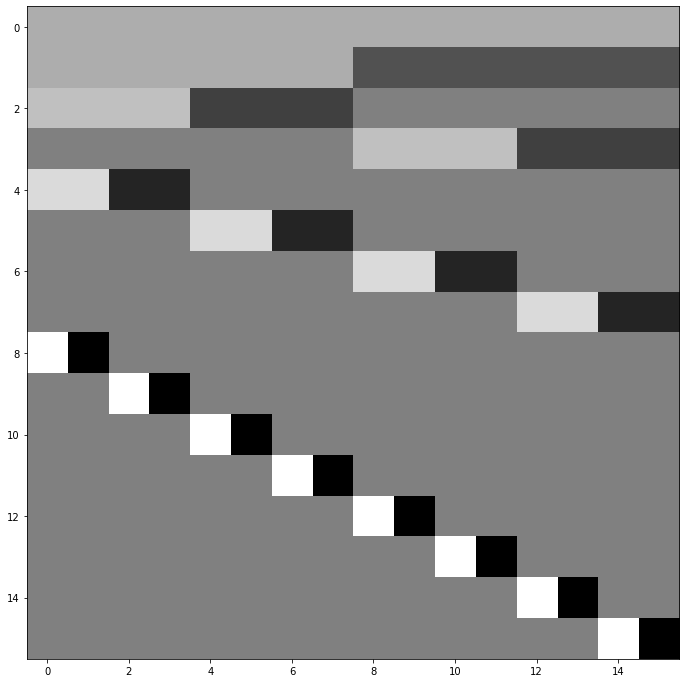

In [3]:
def haar_matrix(n):
    """Returns the Haar matrix. N is a power of two."""

    i = 1
    p = 1
    while p < n:
      p *= 2
      i = i+1

    H = [1]
    NC = 1 / math.sqrt(2)
    LP = [1, 1]
    HP = [1,-1]
    for j in range(1,i):
      H = np.dot(NC, np.concatenate([np.matrix(np.kron(H, LP)), np.matrix(np.kron(np.eye(len(H)), HP))]))
    
    return H


plt.imshow(haar_matrix(16), cmap='gray')
plt.show()

# Exercise 3 - Blending - 10 Points

a) Blend two images (fore.png, back.png, see blending-images.zip in the resources folder in the WhiteBoard (KVV)), by using pyramid blending. You can grayscale all images in order to have only one channel.
Create two Laplace pyramids for the foreground and background image.
Create a Gaussian pyramid for the blending mask image alpha.png. Plot the lowest 3 levels of the three pyramids.
Then apply pyramid blending. Show the lowest 3 levels of the resulting Laplace pyramid and reconstruct the image. Show the blended image.

As an input you can use the images alpha.png, back.png, fore.png given  or use your own images.
You should not use any blending functions or functions which create the Laplacian or Gaussian pyramid for you. Feel free to use a method
of your own choice for the REDUCE and EXPAND function (see slides), especially for the interpolations.

b) Now blend, but not with the full pyramid as in a), instead use 2 levels and later 4 levels of the
Laplacian / Gaussian pyramid, which only contains 2 or 4 levels.

Plot the results (the blended images).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import pylab
import scipy
from skimage.color import rgb2gray
from skimage.filters import gaussian
import PIL
import math

In [5]:
# bilder laden, normalisieren und in grayscale umwandeln

img_back = plt.imread('./Images/orange_test.jpg')
img_back = rgb2gray((img_back / 255.))
img_fore = plt.imread('./Images/apple_test.jpg')
img_fore = rgb2gray((img_fore / 255.))
img_alpha = np.zeros((img_fore.shape[0],img_fore.shape[1]))
img_alpha[:, 0:img_fore.shape[0]//2] = 1

In [6]:
# bewegt einen kernel über das bild für das glätten

def smooth(img):
  kernel = np.array([[0.0025,0.0125,0.02,0.0125,0.0025],
                   [0.0125,0.0625,0.1,0.0625,0.0125],
                   [0.02,0.1,0.16,0.1,0.02],
                   [0.0125,0.0625,0.1,0.0625,0.0125],
                   [0.0025,0.0125,0.02,0.0125,0.0025]])
  
  img = scipy.signal.convolve2d(img,kernel ,'same')
  return img

In [7]:
# löscht jedes zweite pixel/ halbiert das bild

def reduce(img):
  img = img[:img.shape[0]:2, :img.shape[0]:2]
  return img

In [8]:
# vergrößert das bild und glättet um die leeren pixel werte zu füllen

def expand(img):
  kernel = np.array([[0.0025,0.0125,0.02,0.0125,0.0025],
                   [0.0125,0.0625,0.1,0.0625,0.0125],
                   [0.02,0.1,0.16,0.1,0.02],
                   [0.0125,0.0625,0.1,0.0625,0.0125],
                   [0.0025,0.0125,0.02,0.0125,0.0025]])
  output = np.zeros((img.shape[0] * 2, img.shape[1] * 2))
  output[::2, ::2] = img
  return scipy.signal.convolve2d(output, kernel, 'same') * 4

In [9]:
# erstellt die gaussian pyramide

def Gaussian_Pyramid(img, level):
    pyramid = [np.copy(img)]
    for i in range(level):
        blur_img = smooth(pyramid[i])
        downsample_img = reduce(blur_img)
        pyramid.append(downsample_img)
    return pyramid

In [10]:
# erstellt die laplace pyramide

def Laplacian_Pyramid(img, level):
    pyramid = []
    upper_img = np.copy(img)
    for i in range(level):
        blur_img = smooth(upper_img)
        lap = np.copy(upper_img) - np.copy(blur_img)
        pyramid.append(lap)
        upper_img = reduce(blur_img)
        if i == level - 1:
            pyramid.append(upper_img)
    return pyramid

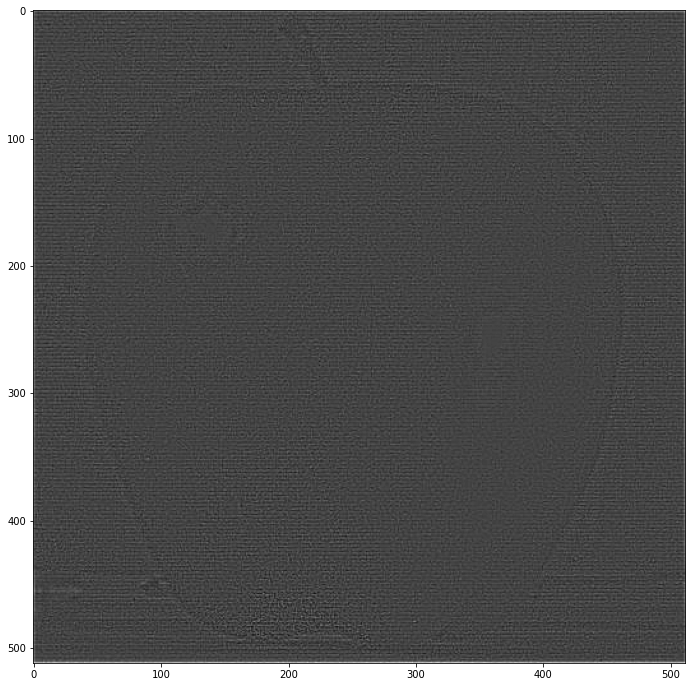

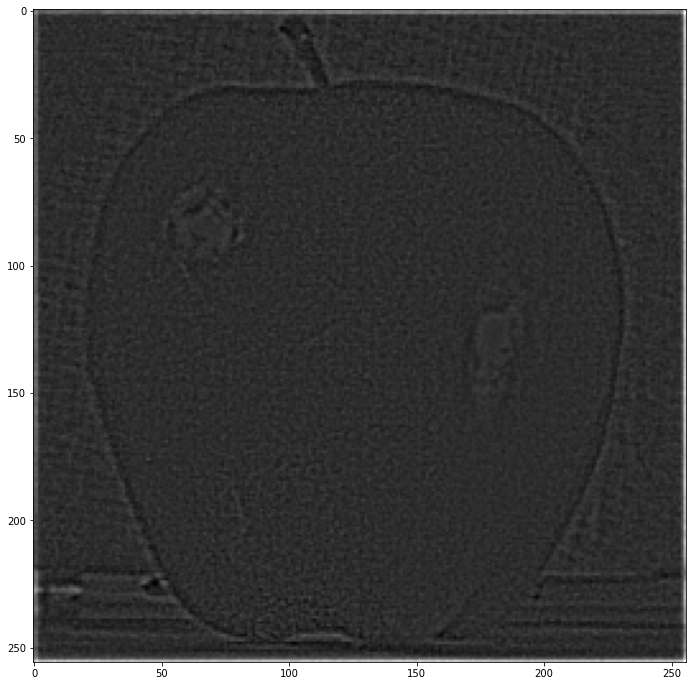

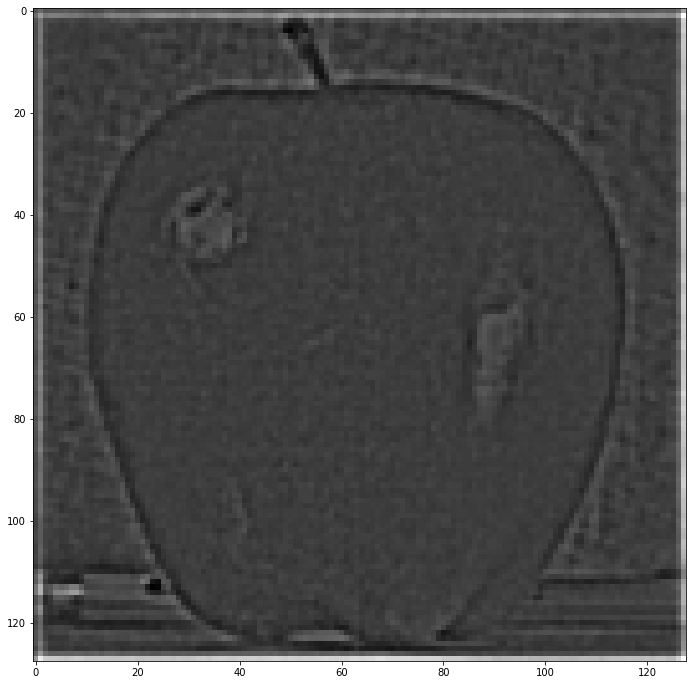

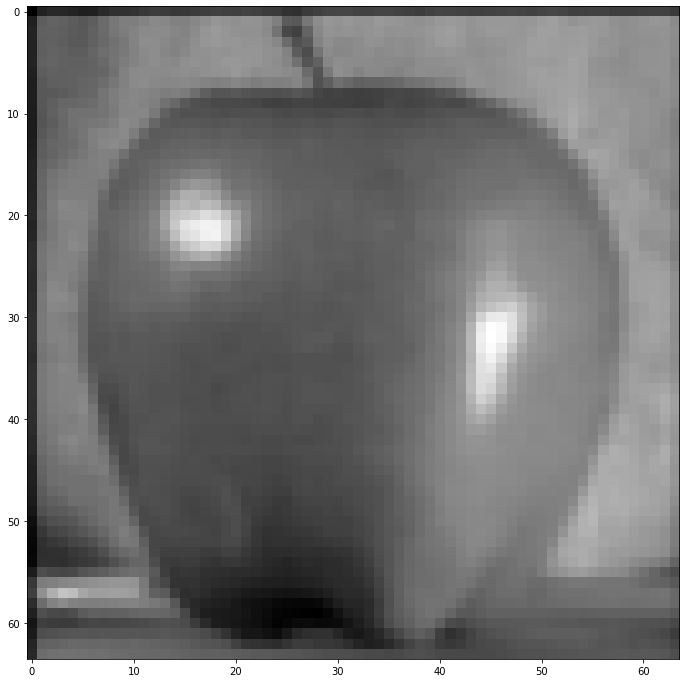

In [11]:
# laplace pyramid für foreground
laplacePyramidForegroundImage = Laplacian_Pyramid(img_fore, 3)
# show lowest three levels
for a in laplacePyramidForegroundImage:
  plt.imshow(a,cmap="gray")
  plt.show()

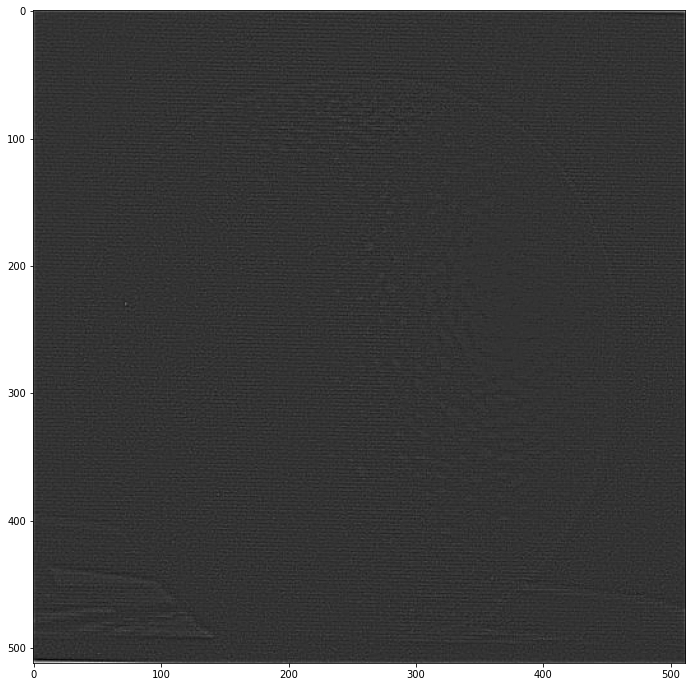

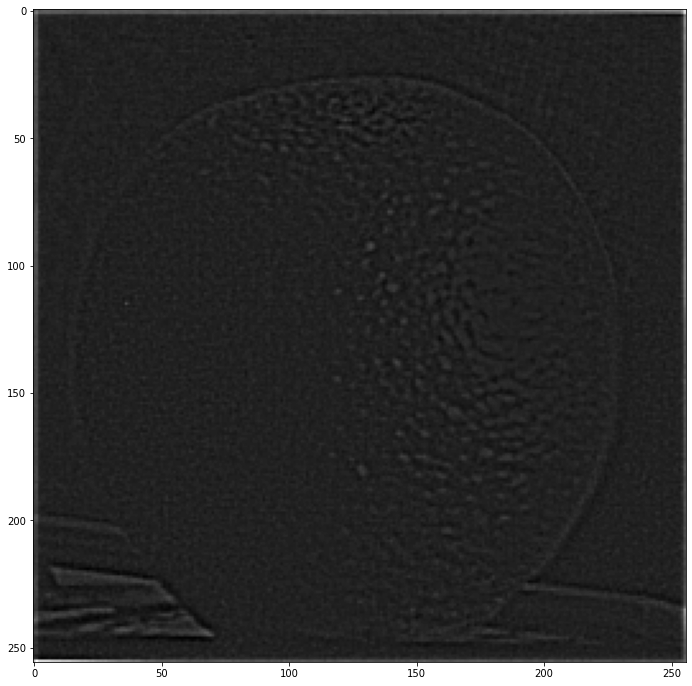

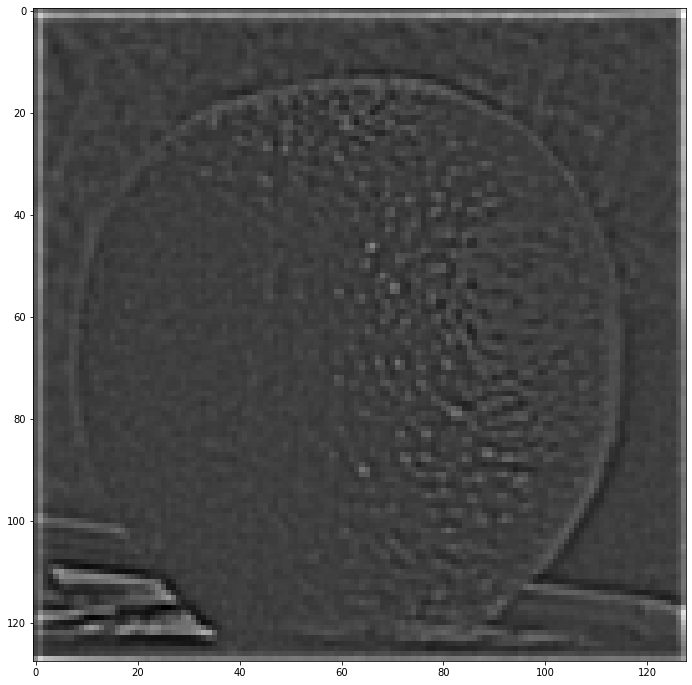

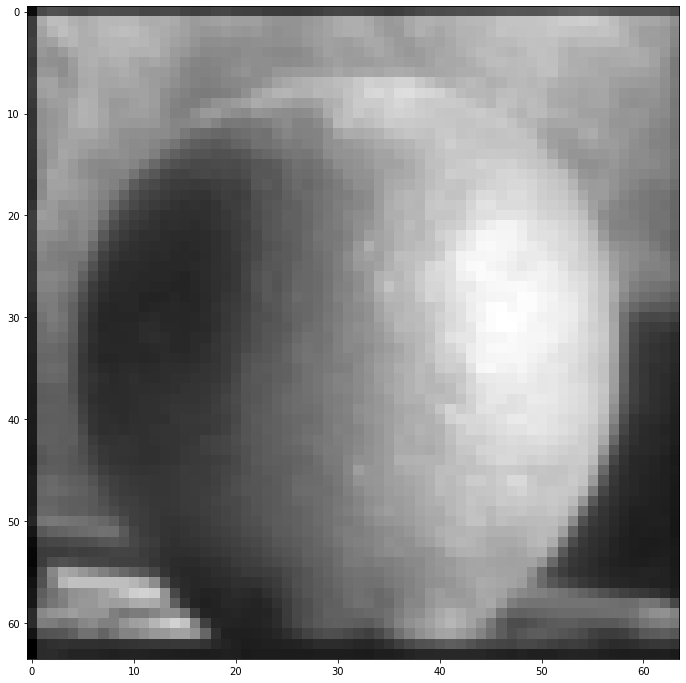

In [12]:
# laplace pyramid for background
laplacePyramidBackgroundImage = Laplacian_Pyramid(img_back, 3)
#show lowest three levels
for a in laplacePyramidBackgroundImage:
  plt.imshow(a,cmap="gray")
  plt.show()

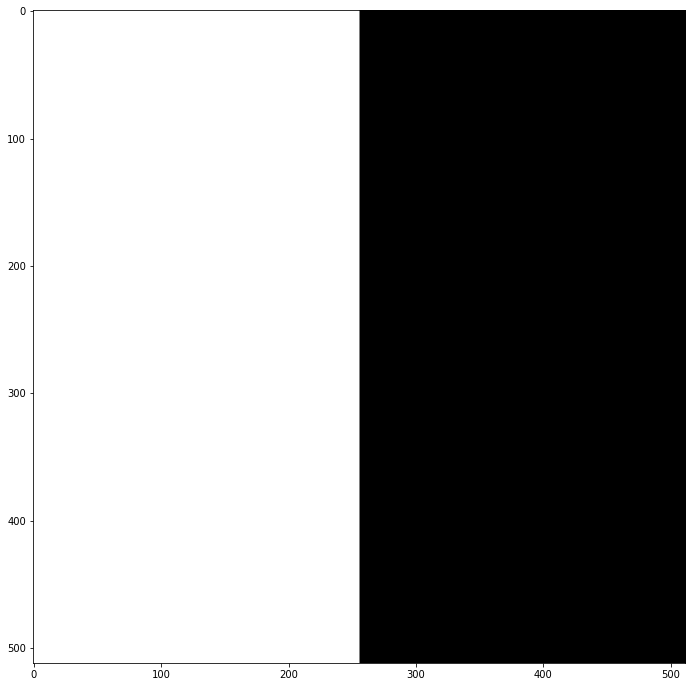

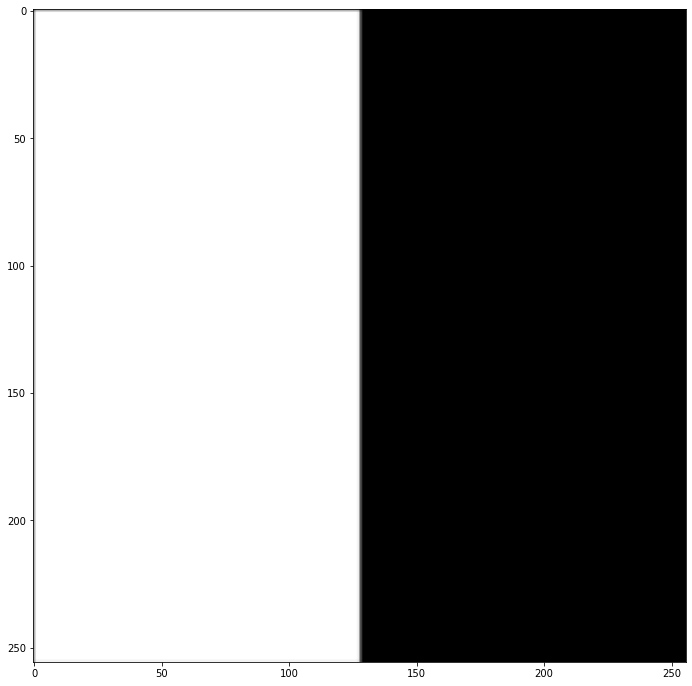

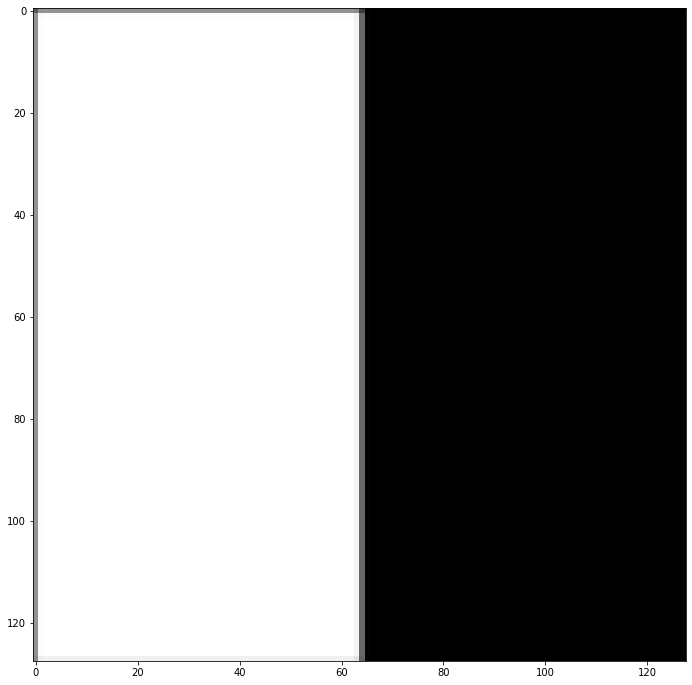

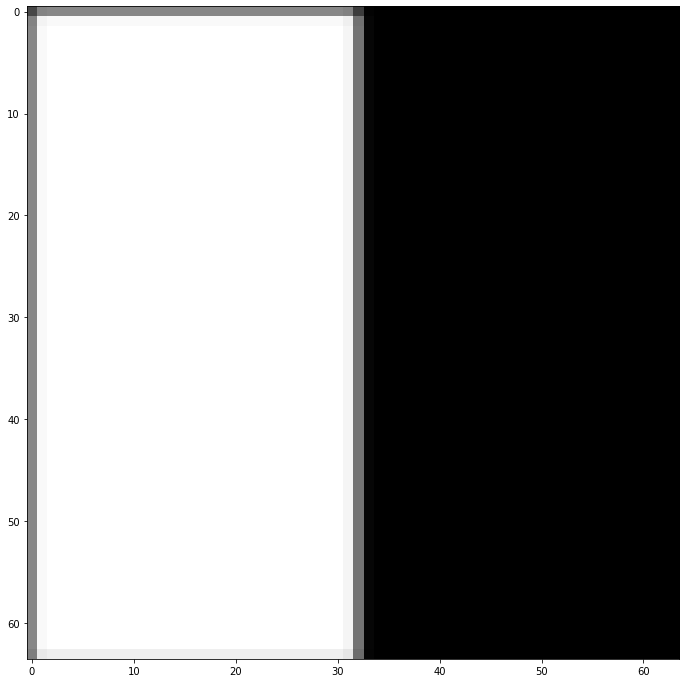

In [13]:
# gaussian pyramid of mask
gaussianPyramidMask = Gaussian_Pyramid(img_alpha, 3)
#show lowest three levels
for a in gaussianPyramidMask:
  plt.imshow(a,cmap="gray")
  plt.show()

In [14]:
# blenden durch die formel

def blend_image(fore, back, mask):
  blend_list = []
  for i in range(0, len(mask)):
    blendedLayer = mask[i]*fore[i] + (1 - mask[i])*back[i]
    blend_list.append(blendedLayer)

  return blend_list

blended_pyramid = blend_image(laplacePyramidForegroundImage, laplacePyramidBackgroundImage, gaussianPyramidMask)

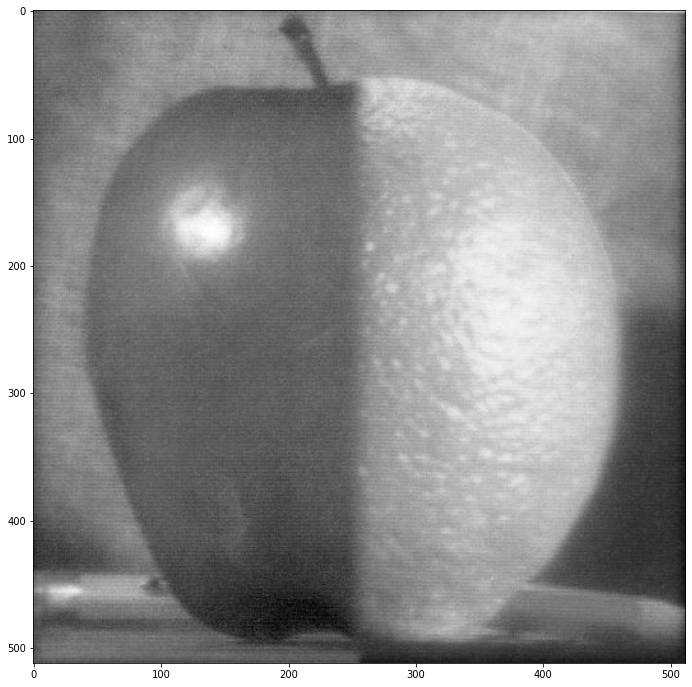

In [15]:
# collapse funktion um das bild wiederherzustellen

def collapse(pyramid, level):
  for i in range(len(pyramid) - 1, 0, -1):
    expandedLayer = expand(pyramid[i])
    pyramid[i - 1] += expandedLayer
  return pyramid[level]

plt.imshow(collapse((blended_pyramid),0), cmap='gray')